# **Osztályozás - a kiegyensúlyozatlan adathalmazok kezelése**
Készítette: Fogarassyné Vathy Ágnes

Cél egy olyan osztályozó készítése, amely képes kezelni az adathalmazban rejlő kiegyensúlyozatlanságot az osztálycímkék tekintetében.

## **1. Adatok beolvasása és előkészítése**

**Block 1.1** Ehhez első lépésben olvassuk be az adathalmazt és nézzük meg mivel is fogunk dolgozni.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [18]:
#from google.colab import drive
#drive.mount("/content/gdrive")

df = pd.read_csv('application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


A TARGET oszlop tartalmazza azt, hogy történt-e csalás a bankkártyával, s ennek az oszlopnak az értékét szeretnénk majd egy osztályozóval előrejelezni.

**Block 1.2** Nézzük meg az osztálycímkék megoszlását.

In [19]:
freq = df['TARGET'].value_counts()
df_freq = pd.DataFrame({'Value':freq.index, 'Count':freq.values})

fig = px.bar(df_freq, x='Value', y='Count', text='Count')
fig.show()

> Mint látjuk, nagyon kiegyenlítetlen a két osztálycímke eloszlása. **No ez az, ami éppen a problémát okozza!**

## **1.1 Adatelőkészítés**

**Block 1.3** Mivel a későbbiekben RandomForestClassifierrel fogunk dolgozni, ezért a kategorikus adatokat át kell konvertálnunk.

- a bináris értékű kategorikus adatok konvertálása 0-1 egész értékű adatokká (GENDER, CAR, REALITY)
- a többértékű katagorikus adatok kovertálása dummy változókká (INCOME_TYPE, EDUCATION_TYPE, FAMILY_TYPE, HOUSE_TYPE)
- felesleges oszlopok törlése ('Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE')

In [20]:
# Remap to integers
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]

# Create dummy variables
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)

# Drop unnecessary columns
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
merged.head()

KeyError: 'GENDER'

## **2. Osztályozás kiegyensúlyozás nélkül**

**Block 2.1** Hozzuk létre a tréning és teszt adathalmazokat és nézzük meg az adathalmazokban a csalások megoszlását!

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,  test_size=0.25, random_state=42
)

print('Pozitív osztály a Tréning adathalmazban: {0:5.2f}%'.format(np.round(y_train.value_counts(normalize=True)[1] * 100, 2)))
print('Pozitív osztály a Teszt adathalmazban: {0:5.2f}%'.format(np.round(y_test.value_counts(normalize=True)[1] * 100, 2)))

**Block 2.2** Készítsünk egy RandomForest osztályozót és nézzük meg az eredményt!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print('Accuracy: {0:5.3f}'.format(accuracy_score(y_test, preds)))
print('Recall: {0:5.3f}'.format(recall_score(y_test, preds)))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Keveredési mátrix (kiegyenlítés nélkül)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

> Oóóóóóóóóóó. Bár a **modell 98,3%-os pontosságú**, **a pozitív osztályt tekintve 92,3%-ban TÉVED**!

## **3. Osztályozás RandomOverSampler-rel történő kiegyensúlyozást követően**

**Block 3.1** Teremtsünk egyensúlyt a véletlen kiválasztáson alapuló [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) segítségével az adathalmazban az osztálycímkék tekintetében.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

randos = RandomOverSampler(random_state=42)

X_randos, y_randos = randos.fit_resample(X, y)

print('X mérete az oversampling előtt: ', X.shape)
print('X mérete az oversampling után: ', X_randos.shape)

print('\nSzázalékos osztályeloszlás a kiegyensúlyozott adathalmazban:')
df_y_randos = pd.DataFrame(y_randos)
df_y_randos.value_counts(normalize=True) * 100

> Most a 25134 objektumunk helyett 49424 objektumunk van és az osztálycímkék megoszlása 50-50%.



**Block 3.2** Jöhet újra az adatok felosztása:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_randos, y_randos, test_size=0.25, random_state=42)

**Block 3.3** Ezt követően pedig hajtsuk végre az osztályozást és értékeljük ki.

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('Accuracy: {0:5.3f}'.format(accuracy_score(y_test, preds)))
print('Recall: {0:5.3f}'.format(recall_score(y_test, preds)))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Keveredési mátrix (RandomOverSampler-rel)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

> Mint láthatjuk, a **pozitív címkéjű egyedeket most a modell 100%-os pontossággal jósolta meg**, míg mellette az **osztályozás pontossága is 99,6%-os**.

> **DE!!!! Ez azért gyanús!!! Hol követtünk el hibát??????**
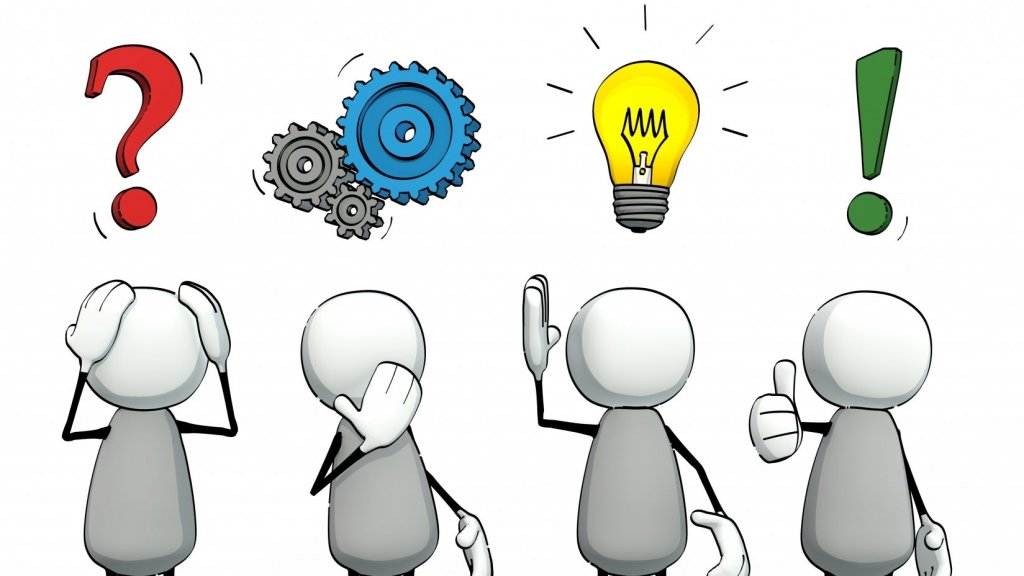

> *A megfejtés: ADATSZIVÁRGÁS*

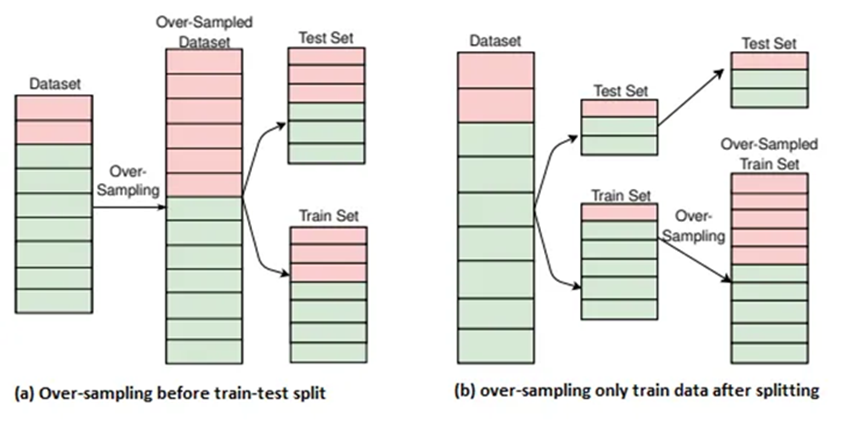

## **4. Osztályozás SMOTE-tal történő kiegyensúlyozást követően**

**Block 4.1** Ehhez a SMOTENC metódust használjuk, amely képes kezelni numerikus és kategorikus adatokat is.

In [ ]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 5, 6, 7])

X_sm, y_sm = sm.fit_resample(X, y)

print('X mérete a SMOTE előtt: ', X.shape)
print('X mérete a SMOTE után: ', X_sm.shape)

print('\nSzázalékos osztályeloszlás a kiegyensúlyozott adathalmazban:')
df_y_sm = pd.DataFrame(y_sm)
df_y_sm.value_counts(normalize=True) * 100

**Block 4.2** A SMOTE futtatása után hozzuk létre a tréning és teszt halmazokat!

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42)

**Block 4.3** Készítsük el és értékeljük ki a Random Forest osztályozónkat!

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print('Accuracy: {0:5.3f}'.format(accuracy_score(y_test, preds)))
print('Recall: {0:5.3f}'.format(recall_score(y_test, preds)))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Keveredési mátrix (SMOTE-tal)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

> A **pozitív címkéjű egyedeket a modell 98,6%-os pontossággal jósolta meg**, míg mellette az **osztályozás pontossága is 98,7%-os**.

    Itt is érdemes lett volna előbb elvégezni a training és test adathalmazok kialakítását?

## **5. Egyéb kiegyensúlyozási módszerek**

Érdemes utánanézni még a **Borderline SMOTE**, az **SVM SMOTE** és a **Kmeans SMOTE** algoritmusoknak, melyek az alap SMOTE algoritmus verziói. Figyelni kell azonban arra, hogy csak folytonos változókat kezelnek-e, vagy tudják-e kezelni a kategorikus adatokat is. (Ha nem kategorikusként kezelik, akkor olyan atribútumértékeket generálnak az oversampling során, amelyek nem is léteznek. Ettől az osztályozás pontossága ugyan nő, azonban mégis csalunk.)

Szintén érdemes megnézni még az **ADASYN** algoritmust is, de ott is felmerül ez a kérdés...